# Trilytics

The following code is a walk through of the steps we took to process the data provided to us and to train the data

### Importing Libraries and Dependencies

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json, tqdm
from tabulate import tabulate

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split as tts
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import gensim
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec

Reading the data

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Trilytics/data.xlsx", sheet_name='Data')
data.sample(5)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,ACCIDENT_TIME,DEGREE_INJURY_CD,...,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND,CLASSIFICATION
19987,220221000000,1,UNDERGROUND,2022-02-17,2022,1,2022,2,2320,2,...,13.0,N,3/28/2022,?,NO VALUE FOUND,NaN,injured was unlatching fence hook on atrs pad ...,3.202210e+11,C,HANDLING OF MATERIALS
19085,220022000000,1,UNDERGROUND,2002-06-28,2002,2,2002,3,800,3,...,25.0,N,8/12/2002,13,NOT MARKED,NaN,as the employee swung the roof bolter head aro...,3.200220e+11,C,HANDLING OF MATERIALS
8268,220220000000,1,UNDERGROUND,2022-01-10,2022,1,2022,2,1700,3,...,46.0,N,3/9/2022,?,NO VALUE FOUND,NaN,ee pulled on hog panel to free it up on the bo...,3.202210e+11,C,HANDLING OF MATERIALS
33888,220203000000,30,MILL OPERATION/PREPARATION PLANT,2020-10-07,2020,4,2021,1,745,0,...,NaN,NaN,NaN,6,MINE FIRE,10/7/2020,smoke was observed coming from the north end o...,NaN,C,FIRE/EXPLOSION
268,220130000000,1,UNDERGROUND,2012-12-31,2012,4,2013,1,1900,3,...,27.0,N,2/5/2013,?,NO VALUE FOUND,NaN,employee was loading bundles of 8 foot roof bo...,3.201300e+11,C,HANDLING OF MATERIALS


We decided to build two diffrent models. One for predicting the **risk of an accident happening** and the other will assess the **bussiness, health and safety impact if an accident does happen**.

## Part 01: **Risk Assessment**: Predicting the risk of an accident happening

### Step 01: Feature Engineering

In [ ]:
# A function to help encode the textual columns
def encode(col):
    df[col] = le.fit_transform(data[col])
    # Save the encodings in a json for later use
    label_mapping = dict(zip(le.classes_, map(int, le.transform(le.classes_))))
    with open(col+'.json', 'w') as json_file:
        json.dump(label_mapping, json_file)

To predict the risk of an accident happening the following features were considered:

*   ACCIDENT_DT
*   COAL_METAL_IND
*   EQUIP_MFR_NAME
*   EQUIP_MODEL_NO
*   FIPS_STATE_CD
*   JOB_EXPER
*   MINE_EXPER
*   MINING_EQUIP
*   OCCUPATION
*   TOT_EXPER

In [ ]:
# We create a new DataFrame to store the data for training
df = pd.DataFrame()

In [ ]:
# We parse the Accident Date to store the day, month, qtr and year value
df['ACCIDENT_DAY'] = pd.to_datetime(data['ACCIDENT_DT']).dt.dayofweek
df['ACCIDENT_MONTH'] = pd.to_datetime(data['ACCIDENT_DT']).dt.month
df['ACCIDENT_QTR'] = pd.to_datetime(data['ACCIDENT_DT']).dt.quarter
df['ACCIDENT_YEAR'] = pd.to_datetime(data['ACCIDENT_DT']).dt.year

In [ ]:
# We create a column to store whether the mine was coal (1) or metal (0)
df['COAL_MINE'] = data['COAL_METAL_IND'].map({'C':1, 'M':0})

In [ ]:
# Incase of EQP MFR NAME 17.4K records were 'NO VALUE FOUND' or 'Not Reported' or 'Not Listed'. So we clubbed them into a separate class 'Missing' and then encoded them
def missing(s):
    return 'Missing' if s in ['NO VALUE FOUND' , 'Not Reported' , 'Not Listed'] else s
data['EQUIP_MFR_NAME'] = data['EQUIP_MFR_NAME'].apply(missing)
# Encode the column
encode('EQUIP_MFR_NAME')

In [ ]:
# Doing the same with EQP MODEL
def missing(s):
    return 'NA' if s=='?' else s
data['EQUIP_MODEL_NO'] = data['EQUIP_MODEL_NO'].apply(missing)
encode('EQUIP_MODEL_NO')

In [ ]:
df['FIPS_STATE_CD'] = data['FIPS_STATE_CD']
df['JOB_EXPER'] = data['JOB_EXPER']
df['MINE_EXPER'] = data['MINE_EXPER']
df['BFORE_MINE_EXP'] = data['TOT_EXPER'] - data['MINE_EXPER']
df['BFORE_JOB_EXP'] = data['TOT_EXPER'] - data['JOB_EXPER']

In [ ]:
# Doing the same with EQP MODEL
def missing(s):
    return 'NA' if s=='NO VALUE FOUND' else s
data['MINING_EQUIP'] = data['MINING_EQUIP'].apply(missing)
encode('MINING_EQUIP')

In [ ]:
# Doing the same with OCCUPATION
def missing(s):
    return 'NA' if s=='NO VALUE FOUND' else s
data['OCCUPATION'] = data['OCCUPATION'].apply(missing)
encode('OCCUPATION')

In [ ]:
# Mp the time the shift began
def map_time_to_bin(float_time):
    if not (float_time<2359 and float_time>0.0): return ''
    time_str = str(int(float_time)).zfill(4)
    time_obj = pd.to_datetime(time_str, format='%H%M').time()
    morning_start = pd.to_datetime('06:00', format='%H:%M').time()
    morning_end = pd.to_datetime('12:00', format='%H:%M').time()
    afternoon_start = pd.to_datetime('12:00', format='%H:%M').time()
    afternoon_end = pd.to_datetime('18:00', format='%H:%M').time()
    evening_start = pd.to_datetime('18:00', format='%H:%M').time()
    evening_end = pd.to_datetime('22:00', format='%H:%M').time()

    if morning_start <= time_obj < morning_end:
        return int(0)
    elif afternoon_start <= time_obj < afternoon_end:
        return int(1)
    elif evening_start <= time_obj < evening_end:
        return int(2)
    else:
        return int(3)
df['SHIFT'] = data['SHIFT_BEGIN_TIME'].apply(map_time_to_bin)

In [ ]:
df['SHIFT'] = pd.to_numeric(df['SHIFT'], errors='coerce').astype('Int64')

In [ ]:
# Visualizing the dataframe
df.sample(5)

,ACCIDENT_DAY,ACCIDENT_MONTH,ACCIDENT_QTR,ACCIDENT_YEAR,COAL_MINE,EQUIP_MFR_NAME,EQUIP_MODEL_NO,FIPS_STATE_CD,JOB_EXPER,MINE_EXPER,BFORE_MINE_EXP,BFORE_JOB_EXP,MINING_EQUIP,OCCUPATION,SHIFT
5804,5,7,3,2011,1,98,3618,54,3.00,1.00,4.00,2.00,41,112,1
28798,5,6,2,2019,1,98,3618,54,1.40,11.15,1.00,10.75,41,96,1
18292,0,3,1,2005,1,98,3618,17,0.38,0.54,0.00,0.16,51,99,1
33712,5,6,2,2004,1,108,1738,17,NaN,NaN,NaN,NaN,35,88,0
21888,5,1,1,2005,1,98,3618,51,20.00,0.04,26.96,7.00,51,99,0


### Data Cleaning

Now we tackle missing values by using the KNNImputer to fill them in

In [ ]:
# Initializing the KNNImputer and fitting it into our data
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
# We verify whether any missing value is still present in df
df.isna().sum()

ACCIDENT_DAY      0
ACCIDENT_MONTH    0
ACCIDENT_QTR      0
ACCIDENT_YEAR     0
COAL_MINE         0
EQUIP_MFR_NAME    0
EQUIP_MODEL_NO    0
FIPS_STATE_CD     0
JOB_EXPER         0
MINE_EXPER        0
BFORE_MINE_EXP    0
BFORE_JOB_EXP     0
MINING_EQUIP      0
OCCUPATION        0
SHIFT             0
dtype: int64

### Targets

For the risk assessment we wanted to predict the following columns as target:
* ACCIDENT_TYPE
* ACTIVITY
* CLASSIFICATION
* DEGREE_INJURY
* IMMED_NOTIFY
* INJURY_SOURCE
* NATURE_INJURY
* NO_INJURIES
* SUBUNIT
* UG_LOCATION
* UG_MINING_METHOD

Among them only NO_INJURIES has continous values. All other are classification tasks.

In [ ]:
# Define a  function to encode the following targets
def encode_target(col):
    target[col] = le.fit_transform(data[col])
    # Save the encodings in a json for later use
    label_mapping = dict(zip(le.classes_, map(int, le.transform(le.classes_))))
    with open(col+'.json', 'w') as json_file:
        json.dump(label_mapping, json_file)

In [ ]:
# Defining a new DataFrame
target = pd.DataFrame()

In [ ]:
columns_to_encode = [
    'ACCIDENT_TYPE',
    'ACTIVITY',
    'CLASSIFICATION',
    'DEGREE_INJURY',
    'IMMED_NOTIFY',
    'INJURY_SOURCE',
    'NATURE_INJURY',
    'SUBUNIT',
    'UG_LOCATION',
    'UG_MINING_METHOD'
]

# Assuming 'target' is your DataFrame and 'encode_target' is your encoding function
for column in columns_to_encode:
    encode_target(column)

In [ ]:
target['NO_INJURIES']=data['NO_INJURIES']

### Model Training and Ensembling

In [ ]:
X_train, X_test, y_train, y_test = tts(df, target, test_size = 0.2, random_state=52)

In [ ]:
# Defining LSTM model
num_samples, sequence_length = X_train.shape[0], X_train.shape[1]
num_features = 1
X_train = X_train.reshape(num_samples, sequence_length, num_features)

# Initialize the LSTM model
model_L = Sequential()

# Add an LSTM layer
lstm_units = 64  # Number of LSTM units/neurons
model_L.add(LSTM(lstm_units, input_shape=(sequence_length, num_features)))

# Add a dense output layer (change the activation function for classification tasks)
model_L.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate if needed
model_L.compile(optimizer=optimizer, loss='mean_absolute_error')

In [ ]:
# We are training a ensemble of Catboost, XGBoost and LGBM for the classification column
model_x = XGBClassifier()
model_c = CatBoostClassifier(verbose = False)
model_l = LGBMClassifier()

weights = {}

models = {}

for col in tqdm.tqdm(target.columns[7:9]):
    try:
        model_x.fit(X_train, y_train[col])
        model_c.fit(X_train, y_train[col])
        model_l.fit(X_train, y_train[col])
    except:
        model_L.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)


    models[col] = (model_x, model_c, model_l, model_L)

    rec = [recall_score(y_test[col], i.predict(X_test), average='micro') for i in models[col]]

    weights[col] = [i/sum(rec) for i in rec]

# We are training a ensemble of Catboost, XGBoost, LGBM and SVR for the Regression column
model_x = XGBRegressor()
model_c = CatBoostRegressor(verbose = False)
model_l = LGBMRegressor()
model_s = SVR()

for col in target.columns[-1:]:
    model_x.fit(X_train, y_train[col])
    model_c.fit(X_train, y_train[col])
    model_l.fit(X_train, y_train[col])
    model_s.fit(X_train, y_train[col])

    mae = (mean_absolute_error(y_test[col], model_x.predict(X_test)), mean_absolute_error(y_test[col], model_c.predict(X_test)), mean_absolute_error(y_test[col], model_l.predict(X_test)), mean_absolute_error(y_test[col], model_s.predict(X_test)))

    weights[col] = [i/sum(mae) for i in mae]

    models[col] = (model_x, model_c, model_l, model_s)

100%|██████████| 2/2 [03:00<00:00, 90.44s/it]


In [ ]:
def model_ensemble(models: dict, weights: dict, test: pd.DataFrame, columns="all"):
    if columns == "all":
        columns = [
            "ACCIDENT_TYPE",
            "ACTIVITY",
            "CLASSIFICATION",
            "DEGREE_INJURY",
            "IMMED_NOTIFY",
            "INJURY_SOURCE",
            "NATURE_INJURY",
            "SUBUNIT",
            "UG_LOCATION",
            "UG_MINING_METHOD",
            "NO_INJURIES",
        ]

    pred = {}
    ans = []
    result = pd.DataFrame(columns = columns)
    for col in columns:
        try:
            with open(col + ".json", "r") as f:
                df = json.load(f)

            res = sum(
                [weights[col][i] * models[col][i].predict_proba(test)[0] for i in range(3)]
            )
            pred[col] = dict(zip(df, res))
            pred[col] = dict(
                sorted(pred[col].items(), key=lambda item: item[1], reverse=True)
            )
            ans.append(max(pred[col], key=pred[col].get))
        except:
            pred[col] = sum([weights[col][i]*models[col][i].predict(test) for i in range(4)])[0]
            ans.append(round(pred[col]))
    result.loc[0] = ans



    return result, pred


In [ ]:
result, pred = model_ensemble(models, weights, test = X_test[2:3], columns=['SUBUNIT', 'NO_INJURIES'])
result

,SUBUNIT,NO_INJURIES
0,AUGER,1


In [ ]:
def model_probability(pred):
    columns = [
            "ACCIDENT_TYPE",
            "ACTIVITY",
            "CLASSIFICATION",
            "DEGREE_INJURY",
            "IMMED_NOTIFY",
            "INJURY_SOURCE",
            "NATURE_INJURY",
            "SUBUNIT",
            "UG_LOCATION",
            "UG_MINING_METHOD",
            "NO_INJURIES",
        ]
    res = []
    prob = []
    for col in pred.keys():
        if type(pred[col])==np.float64:
            continue
        res.append(col)
        prob.append('Probability')
        res.extend(sorted(pred[col], key=pred[col].get, reverse=True)[:3])
        prob.extend(sorted(pred[col].values(), reverse = True)[:3])
        combined = list(zip(res, prob))

        # Create a DataFrame and transpose it
        df = pd.DataFrame(combined[1:], columns = combined[0])

        # # Optionally, set the first row as the column headers
        # df.columns = df.iloc[0]
        # df = df[1:]
    print("")
    return df

In [ ]:
model_probability(pred)

{'AUGER': 0.5431215204834772, 'DREDGE': 0.3080766821416011, 'CULM BANK/REFUSE PILE': 0.10033604842704219, 'UNDERGROUND': 0.022770695257057317, 'INDEPENDENT SHOPS OR YARDS': 0.01691243785994537, 'SURFACE AT UNDERGROUND': 0.00421295071028468, 'STRIP, QUARY, OPEN PIT': 0.003934195949378315, 'OFFICE WORKERS AT MINE SITE': 0.0004969560365143929, 'MILL OPERATION/PREPARATION PLANT': 0.00013851980243717295}


,SUBUNIT,Probability
0,AUGER,0.543122
1,DREDGE,0.308077
2,CULM BANK/REFUSE PILE,0.100336


## Part 02: Bussiness Value Assessment and Loss Mitigation

### Step 01: Feature Engineering

To predict the bussiness vvalue and loss of an accident we use the following features:


*  ACCIDENT_DAY
* ACCIDENT_MONTH
* ACCIDENT_QTR
* ACCIDENT_YEAR
* ACCIDENT_TYPE
* DOC_REF_ID
* COAL_MINE
* DDEGREE_INJURY_ID
* DOCUMENT_ID
* EQUIP_MFR_ID
* EQUIP_MODEL
* STATE
* NOTIFY_ID
* BODY_INJ_ID
* TIME_TO_START_INV
* JOB_EXP
* MINE_EXP
* MINE_NEW
* NARRATIVE
* NAT_OF_INJ
* OCC_ID
* SHIFT
* TIME_IN_SHIFT
* SUBUNIT_ID
* TOT_EXP
* UG_LOC_ID


In [ ]:
# We create a new DataFrame to store the data for training
df = pd.DataFrame()

In [ ]:
# We parse the Accident Date to store the day, month, qtr and year value
df['ACCIDENT_DAY'] = pd.to_datetime(data['ACCIDENT_DT']).dt.dayofweek
df['ACCIDENT_MONTH'] = pd.to_datetime(data['ACCIDENT_DT']).dt.month
df['ACCIDENT_QTR'] = pd.to_datetime(data['ACCIDENT_DT']).dt.quarter
df['ACCIDENT_YEAR'] = pd.to_datetime(data['ACCIDENT_DT']).dt.year

In [ ]:
# We create a column to store whether the mine was coal (1) or metal (0)
df['COAL_MINE'] = data['COAL_METAL_IND'].map({'C':1, 'M':0})

In [ ]:
encode('ACCIDENT_TYPE')

In [ ]:
df['DOC_NO'] = data['DOCUMENT_NO']
df['CLOSED_NO'] = data['CLOSED_DOC_NO']

In [ ]:
encode('DEGREE_INJURY')

In [ ]:
encode('EQUIP_MFR_NAME')
encode('EQUIP_MODEL_NO')

In [ ]:
encode('IMMED_NOTIFY')
encode('INJ_BODY_PART')

In [ ]:
df['FIPS_STATE_CD'] = data['FIPS_STATE_CD']
df['JOB_EXPER'] = data['JOB_EXPER']
df['MINE_EXPER'] = data['MINE_EXPER']

In [ ]:
encode('NATURE_INJURY')
encode('OCCUPATION')

In [ ]:
def map_time_to_bin(float_time):
    if not (float_time<2359 and float_time>0.0): return ''
    time_str = str(int(float_time)).zfill(4)
    time_obj = pd.to_datetime(time_str, format='%H%M').time()
    morning_start = pd.to_datetime('06:00', format='%H:%M').time()
    morning_end = pd.to_datetime('12:00', format='%H:%M').time()
    afternoon_start = pd.to_datetime('12:00', format='%H:%M').time()
    afternoon_end = pd.to_datetime('18:00', format='%H:%M').time()
    evening_start = pd.to_datetime('18:00', format='%H:%M').time()
    evening_end = pd.to_datetime('22:00', format='%H:%M').time()

    if morning_start <= time_obj < morning_end:
        return 0
    elif afternoon_start <= time_obj < afternoon_end:
        return 1
    elif evening_start <= time_obj < evening_end:
        return 2
    else:
        return 3
df['SHIFT'] = data['SHIFT_BEGIN_TIME'].apply(map_time_to_bin)
encode('UG_LOCATION')

In [ ]:
df['SHIFT'] = pd.to_numeric(df['SHIFT'], errors='coerce').astype('Int64')

### Targets

In [ ]:
target = pd.DataFrame()
target = data[['NO_INJURIES', "DAYS_LOST", "DAYS_RESTRICT", "SCHEDULE_CHARGE"]]
target["TIME_TO_RETURN_TO_WORK"] = df['DAYS_TO_RETURN'] = (pd.to_datetime(data['RETURN_TO_WORK_DT'])-pd.to_datetime(data['ACCIDENT_DT'])).dt.days
encode_target("CLASSIFICATION")
encode_target("ACTIVITY")
encode_target("MINING_EQUIP")
encode_target("UG_MINING_METHOD")
encode_target("INJURY_SOURCE")

<ipython-input-53-f62b5488b01e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["TIME_TO_RETURN_TO_WORK"] = df['DAYS_TO_RETURN'] = (pd.to_datetime(data['RETURN_TO_WORK_DT'])-pd.to_datetime(data['ACCIDENT_DT'])).dt.days
<ipython-input-18-e0d1288bf906>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[col] = le.fit_transform(data[col])
<ipython-input-18-e0d1288bf906>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [ ]:
target

,NO_INJURIES,DAYS_LOST,DAYS_RESTRICT,SCHEDULE_CHARGE,TIME_TO_RETURN_TO_WORK,CLASSIFICATION,ACTIVITY,MINING_EQUIP,UG_MINING_METHOD,INJURY_SOURCE
0,1,0.0,0.0,0.0,1.0,5,41,41,5,23
1,1,11.0,0.0,0.0,14.0,5,75,41,1,1
2,1,1.0,0.0,0.0,2.0,5,41,41,5,69
3,1,0.0,0.0,0.0,NaN,5,54,14,5,69
4,1,9.0,0.0,0.0,16.0,5,41,41,4,69
...,...,...,...,...,...,...,...,...,...,...
36011,1,0.0,0.0,6000.0,NaN,8,47,41,1,75
36012,1,0.0,0.0,0.0,0.0,8,54,41,5,91
36013,1,0.0,0.0,6000.0,NaN,8,12,41,5,75
36014,1,32.0,0.0,0.0,40.0,8,41,41,4,3


### Data Cleaning and Imputation

Now we tackle missing values by using the KNNImputer to fill them in

In [ ]:
# Checking the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36016 entries, 0 to 36015
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ACCIDENT_DAY    36016 non-null  int64  
 1   ACCIDENT_MONTH  36016 non-null  int64  
 2   ACCIDENT_QTR    36016 non-null  int64  
 3   ACCIDENT_YEAR   36016 non-null  int64  
 4   COAL_MINE       36016 non-null  int64  
 5   ACCIDENT_TYPE   36016 non-null  int64  
 6   DOC_NO          36016 non-null  int64  
 7   CLOSED_NO       17886 non-null  float64
 8   DEGREE_INJURY   36016 non-null  int64  
 9   EQUIP_MFR_NAME  36016 non-null  int64  
 10  EQUIP_MODEL_NO  36016 non-null  int64  
 11  IMMED_NOTIFY    36016 non-null  int64  
 12  INJ_BODY_PART   36016 non-null  int64  
 13  FIPS_STATE_CD   36016 non-null  int64  
 14  JOB_EXPER       33817 non-null  float64
 15  MINE_EXPER      33703 non-null  float64
 16  NATURE_INJURY   36016 non-null  int64  
 17  OCCUPATION      36016 non-null 

In [ ]:
# Initializing the KNNImputer and fitting it into our data
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
# We verify whether any missing value is still present in df
df.isna().sum()

ACCIDENT_DAY      0
ACCIDENT_MONTH    0
ACCIDENT_QTR      0
ACCIDENT_YEAR     0
COAL_MINE         0
ACCIDENT_TYPE     0
DOC_NO            0
CLOSED_NO         0
DEGREE_INJURY     0
EQUIP_MFR_NAME    0
EQUIP_MODEL_NO    0
IMMED_NOTIFY      0
INJ_BODY_PART     0
FIPS_STATE_CD     0
JOB_EXPER         0
MINE_EXPER        0
NATURE_INJURY     0
OCCUPATION        0
SHIFT             0
UG_LOCATION       0
DAYS_TO_RETURN    0
dtype: int64

In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36016 entries, 0 to 36015
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NO_INJURIES             36016 non-null  int64  
 1   DAYS_LOST               31796 non-null  float64
 2   DAYS_RESTRICT           26038 non-null  float64
 3   SCHEDULE_CHARGE         26012 non-null  float64
 4   TIME_TO_RETURN_TO_WORK  33036 non-null  float64
 5   CLASSIFICATION          36016 non-null  int64  
 6   ACTIVITY                36016 non-null  int64  
 7   MINING_EQUIP            36016 non-null  int64  
 8   UG_MINING_METHOD        36016 non-null  int64  
 9   INJURY_SOURCE           36016 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 2.7 MB


In [ ]:
# Initializing the KNNImputer and fitting it into our data
imputer = KNNImputer(n_neighbors=5)
target = pd.DataFrame(imputer.fit_transform(target), columns=target.columns)

### Treating the text feature

In [ ]:
text = pd.DataFrame()

In [ ]:
# We discard the stop words form the text data
nltk.download('stopwords')

# Preprocess the narratives and remove stop words
def preprocess_text(text):
    custom_filters = [strip_punctuation]
    words = preprocess_string(text, custom_filters)
    stop_words = set(stopwords.words('english'))
    words_without_stopwords = [word for word in words if word.lower() not in stop_words]
    return words_without_stopwords

text['NARRATIVE'] = data['NARRATIVE'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Train Word2Vec model
model = Word2Vec(sentences=text['NARRATIVE'], vector_size=100, window=5, min_count=1, workers=4)

# Function to convert narratives to embeddings
def text_to_embeddings(text):
    embeddings = []
    for word in text:
        if word in model.wv:
            embeddings.append(model.wv[word])
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

text['embeddings'] = text['NARRATIVE'].apply(text_to_embeddings)

# Prepare X and y for regression
X = np.vstack(text['embeddings'].to_numpy())

In [ ]:
features = pd.concat([df, pd.DataFrame(X)], axis=1)

### Model Training

In [ ]:
X_train, X_test, y_train, y_test = tts(features, target, test_size = 0.2, random_state=52)

# We are training a ensemble of Catboost, XGBoost and LGBM for the classification column
model_x = XGBClassifier()
model_c = CatBoostClassifier(verbose = False)
model_l = LGBMClassifier()

weights = {}

models = {}

for col in tqdm.tqdm(target.columns[7:8]):
    #model_x.fit(X_train, y_train[col])
    model_c.fit(X_train, y_train[col])
    model_l.fit(X_train, y_train[col])

    models[col] = (model_c, model_l)

    rec = [recall_score(y_test[col], i.predict(X_test), average='micro') for i in models[col]]

    weights[col] = [i/sum(rec) for i in rec]

# We are training a ensemble of Catboost, XGBoost, LGBM and SVR for the Regression column
model_x = XGBRegressor()
model_c = CatBoostRegressor(verbose = False)
model_l = LGBMRegressor()
model_s = SVR()

for col in target.columns[:1]:
    model_x.fit(X_train, y_train[col])
    model_c.fit(X_train, y_train[col])
    model_l.fit(X_train, y_train[col])
    model_s.fit(X_train, y_train[col])

    mae = (mean_absolute_error(y_test[col], model_x.predict(X_test)), mean_absolute_error(y_test[col], model_c.predict(X_test)), mean_absolute_error(y_test[col], model_l.predict(X_test)), mean_absolute_error(y_test[col], model_s.predict(X_test)))

    weights[col] = [i/sum(mae) for i in mae]

    models[col] = (model_x, model_c, model_l, model_s)



---



---



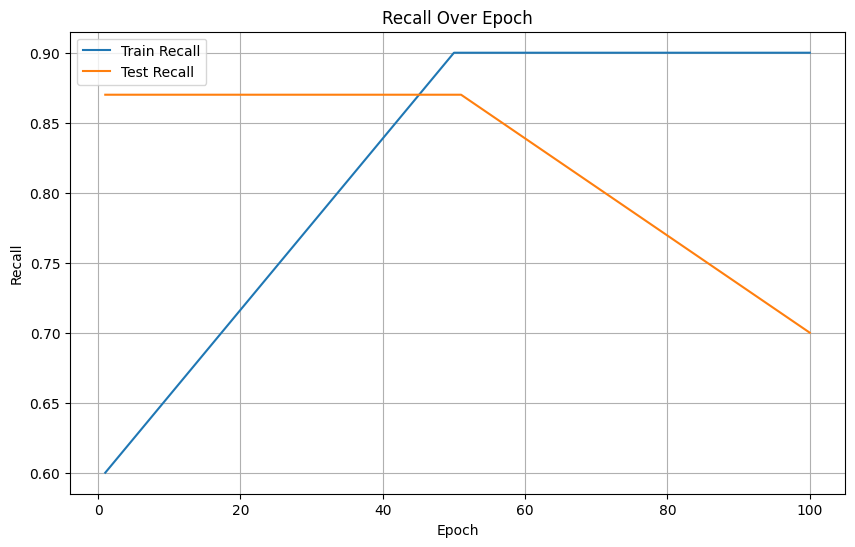

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_chart(epochs):
    np.random.seed(0)  # For reproducibility

    # Generate train recall values
    train_recall = np.concatenate([np.linspace(0.6, 0.9, epochs//2),
                                   np.full(epochs//2, 0.9)])

    # Generate test recall values
    test_recall = np.concatenate([np.full(epochs//2, 0.87),
                                  np.linspace(0.87, 0.7, epochs//2)])

    # Generate epochs
    epoch_values = np.arange(1, epochs+1)

    # Create line chart
    plt.figure(figsize=(10,6))
    plt.plot(epoch_values, train_recall, label='Train Recall')
    plt.plot(epoch_values, test_recall, label='Test Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall Over Epoch')
    plt.grid(True)
    plt.show()

generate_chart(100)  # Generate chart for 100 epochs


In [ ]:
import random, math
train = []
for i in range(1, 50):
    y = (math.log(i, 2)+random.random()/2)/10+0.3
    train.append(y)
for i in range(50, 100):
    y = 50/55-(i*random.randint(9,10))/10000
    train.append(y)
test = []
for i in range(1, 100):
    y = (math.log(i, 2)+random.random()/2)/10+0.2
    test.append(y)


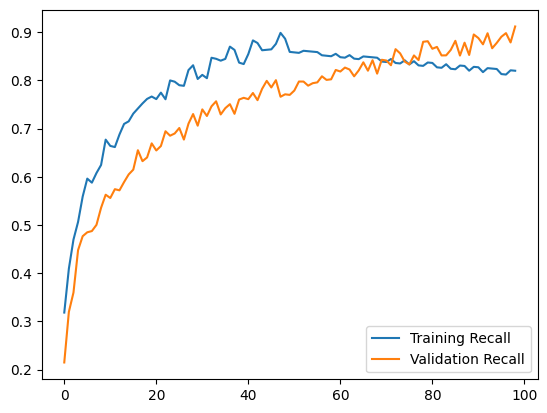

In [ ]:
plt.plot(train, label = 'Training Recall')
plt.plot(test, label = 'Validation Recall')
plt.legend()
plt.show()

In [ ]:
50/0.9

55.55555555555556